In [4]:
!uname -m

aarch64


In [ ]:
#!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet arviz bambi preliz kulprit)"

In [49]:
%load_ext autoreload
%autoreload 2

import pymc as pm
import xarray as xr
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from pytensor import tensor as pt

print("pymc.version=", pm.__version__)
print("arviz.version=", az.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pymc.version= 5.16.2
arviz.version= 0.19.0


In [2]:
plt.rcParams["figure.figsize"] = [8, 3]

dir_name = "/aux/code/book.2018.Martin.Bayesian_Analysis_with_Python.2e"

# Chap 6: Mixture models

In [5]:
cs = pd.read_csv(dir_name + "/data2/chemical_shifts_theo_exp.csv")
cs_exp = cs["exp"]
display(cs_exp.head())

0    58.27
1    56.18
2    56.84
3    51.01
4    54.64
Name: exp, dtype: float64

In [10]:
print(len(cs_exp))

1776


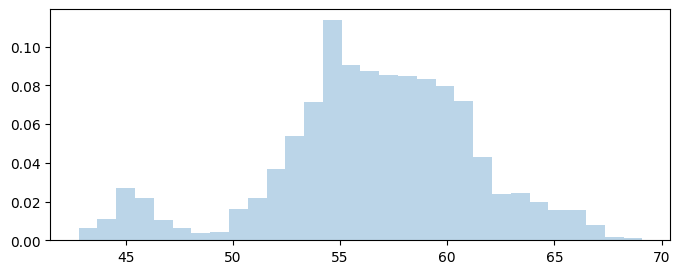

In [9]:
_, ax = plt.subplots()
plt.hist(cs_exp, density=True, bins=30, alpha=0.3);

In [12]:
# The parameters to estimate are:
# - latent variable (which is a vector with as many components as data points) coming from a Dirichlet
#   - All vars are estimated together as hierarchical model.
# - distributions of the 2 Gaussians
K = 2
with pm.Model() as model_kg:
    # Prior p ~ Dirichlet([1, 1]), which is a Beta.
    p = pm.Dirichlet("p", a=np.ones(K))
    # Assign each data point a RV with a Dirichlet prior, using latent variable "z".
    z = pm.Categorical("z", p=p, shape=len(cs_exp))
    # 2 Gaussians with different mean and same std.
    means = pm.Normal("means", mu=cs_exp.mean(), sigma=10, shape=K)
    sd = pm.HalfNormal("sd", sigma=10)
    # The distribution is a Gaussian whose means are function of the latent variable.
    y = pm.Normal("y", mu=means[z], sigma=sd, observed=cs_exp)
    trace_kg = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, means, sd]
>BinaryGibbsMetropolis: [z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 167 seconds.
/venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


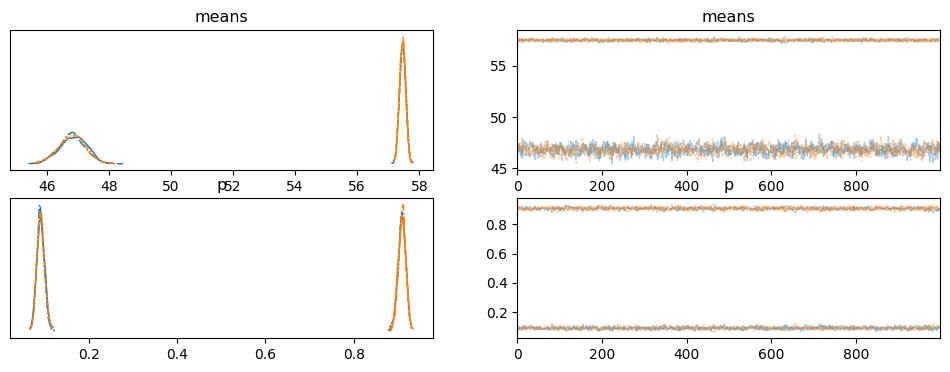

In [13]:
varnames = ["means", "p"]
az.plot_trace(trace_kg, varnames);

In [14]:
az.summary(trace_kg, varnames)  # , kind="stats")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],52.152,5.324,46.271,57.661,2.647,2.027,6.0,155.0,1.74
means[1],52.145,5.329,46.262,57.653,2.650,2.029,6.0,119.0,1.73
p[0],0.500,0.410,0.077,0.922,0.204,0.156,6.0,151.0,1.73
p[1],0.500,0.410,0.078,0.923,0.204,0.156,6.0,151.0,1.73


### Marginalization

In [15]:
# The previous is slow and ineffective since we have explicitly included the latent variable `z`.
# We can re-parametrize the model using `pm.NormalMixture`.
clusters = 2
with pm.Model() as model_mg:
    # Same as before.
    p = pm.Dirichlet("p", a=np.ones(clusters))
    means = pm.Normal("means", mu=cs_exp.mean(), sigma=10, shape=clusters)
    sd = pm.HalfNormal("sd", sigma=10)
    # Different.
    y = pm.NormalMixture("y", w=p, mu=means, sigma=sd, observed=cs_exp)
    trace_mg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
# ?az.summary

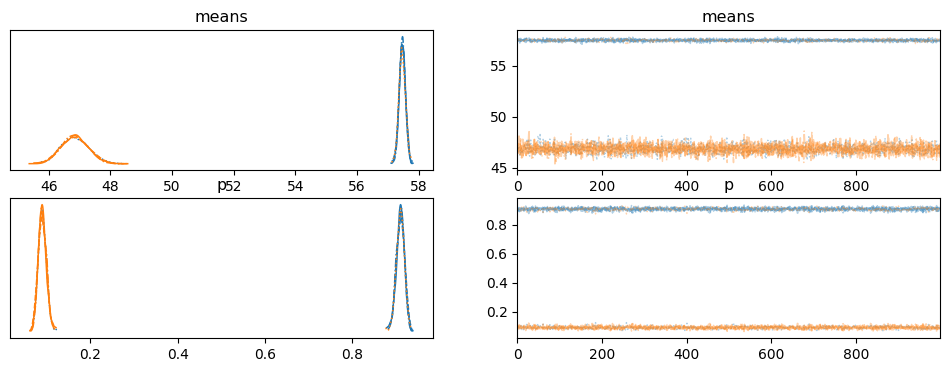

In [16]:
varnames = ["means", "p"]
az.plot_trace(trace_mg, varnames);

In [17]:
az.summary(trace_mg, varnames)  # , kind="stats")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],54.815,4.600,46.491,57.698,2.288,1.752,7.0,34.0,1.53
means[1],49.498,4.615,46.176,57.631,2.291,1.754,7.0,30.0,1.53
p[0],0.705,0.355,0.082,0.927,0.177,0.135,7.0,30.0,1.53
p[1],0.295,0.355,0.073,0.918,0.177,0.135,7.0,30.0,1.53


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

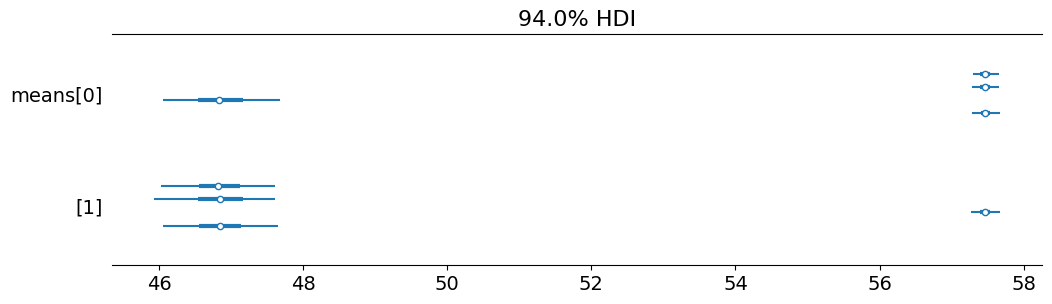

In [21]:
az.plot_forest(trace_mg, var_names="means", figsize=(12, 3))

## How to choose K

In [23]:
cs_exp.head()

0    58.27
1    56.18
2    56.84
3    51.01
4    54.64
Name: exp, dtype: float64

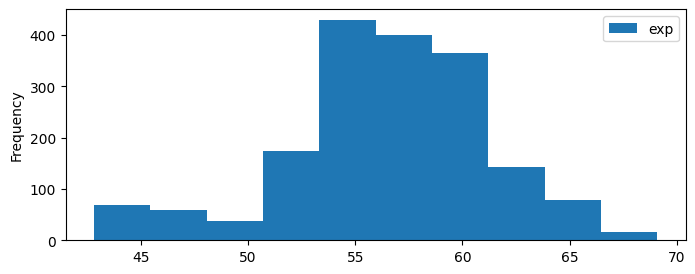

In [26]:
pd.DataFrame(cs_exp).plot(kind="hist");

In [35]:
Ks = [2, 3, 4, 5]

models = []
idatas = []
for k in Ks:
    print(k)
    mu = np.linspace(cs_exp.min(), cs_exp.max(), k)
    sigma = cs_exp.var() / k
    #
    with pm.Model() as model:
        # Model.
        p = pm.Dirichlet("p", a=np.ones(k))
        means = pm.Normal(
            "means",
            mu=mu,
            sigma=sigma,
            shape=k,
            transform=pm.distributions.transforms.ordered,
        )
        sd = pm.HalfNormal("sd", sigma=5)
        y = pm.NormalMixture("y", w=p, mu=means, sigma=sd, observed=cs_exp)
        # Sample.
        idata = pm.sample(idata_kwargs={"log_likelihood": True})
        # Store.
        idatas.append(idata)
        models.append(model)

2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [ ]:
# TODO

In [36]:
comp = az.compare(dict(zip([str(K) for K in Ks], idatas)))
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
5,0,-5129.329796,10.001254,0.000000,1.000000e+00,30.752451,0.000000,False,log
4,1,-5139.410409,7.416497,10.080613,0.000000e+00,31.271669,4.010193,False,log
3,2,-5178.491375,5.956077,49.161579,0.000000e+00,31.901067,8.800723,False,log
2,3,-5215.885419,3.238820,86.555622,2.924168e-10,33.510139,11.962113,False,log


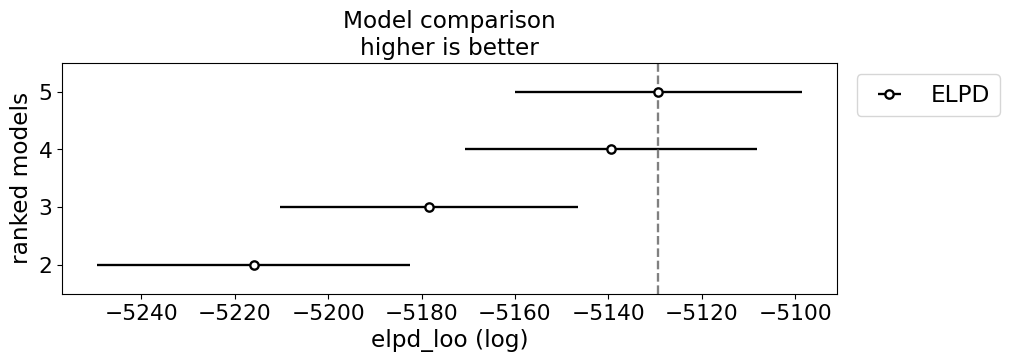

In [38]:
az.plot_compare(comp, figsize=(10, 3), plot_ic_diff=False);

## Zero-inflated model

In [42]:
fish_data = pd.read_csv(dir_name + "/data2/fish.csv")
print(fish_data.shape)
fish_data.head()

(250, 6)


,nofish,livebait,camper,persons,child,count
0,1,0,0,1,0,0
1,0,1,1,1,0,0
2,0,1,0,1,0,0
3,0,1,1,2,1,0
4,0,1,0,1,0,1


In [ ]:
- 250 groups of visitors to a park
- nofish: number of fish caught
- camper: whether they brought a camper to the park (indicator variable)
- child: how many children in the group

In [46]:
with pm.Model() as ZIP_reg:
    # Prior for the proportion of Poisson draws (the probability of a non-zero count)
    # The Beta(1, 1) is a uniform prior over [0, 1], meaning no strong prior belief.
    psi = pm.Beta("Psi", 1, 1)
    
    # Prior for the intercept (baseline effect) in the log-linear model for the Poisson rate.
    # A Normal(0, 1) prior reflects uncertainty about the mean of the log-rate, centered at 0.
    alpha = pm.Normal("alpha", 0, 1)
    
    # Priors for the coefficients of two predictors (child and camper).
    # Normal(0, 1) priors assume no strong belief about the effect size of these predictors.
    # Shape=2 means there are two coefficients (one for each predictor).
    beta = pm.Normal("beta", 0, 1, shape=2)
    
    # The expected rate (lambda) for the Poisson distribution.
    # This is modeled using a log-linear regression: exp(alpha + beta1 * child + beta2 * camper).
    # The predictors "child" and "camper" come from the dataset fish_data.
    theta = pm.math.exp(alpha + beta[0] * fish_data["child"] + beta[1] * fish_data["camper"])
    
    # Likelihood function for the observed count data.
    # Using a Zero-Inflated Poisson distribution, where:
    #   - psi is the probability of drawing from the Poisson part (non-zero counts).
    #   - theta is the Poisson rate parameter (lambda).
    # The observed data (fish_data["count"]) are the counts being modeled.
    y = pm.ZeroInflatedPoisson("yl", psi, theta, observed=fish_data["count"])

    #
    idata_ZIP_reg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Psi, alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


<xarray.Dataset> Size: 224kB
Dimensions:     (sample: 4000, beta_dim_0: 2)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 16B 0 1
  * sample      (sample) object 32kB MultiIndex
  * chain       (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  * draw        (sample) int64 32kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    Psi         (sample) float64 32kB 0.4794 0.4613 0.4948 ... 0.5246 0.493
    alpha       (sample) float64 32kB 1.654 1.647 1.686 ... 1.476 1.474 1.417
    beta        (beta_dim_0, sample) float64 64kB -0.9079 -0.8893 ... 1.02 1.006
Attributes:
    created_at:                 2024-10-14T11:27:52.958931+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              2.8050010204315186
    tuning_steps:               1000


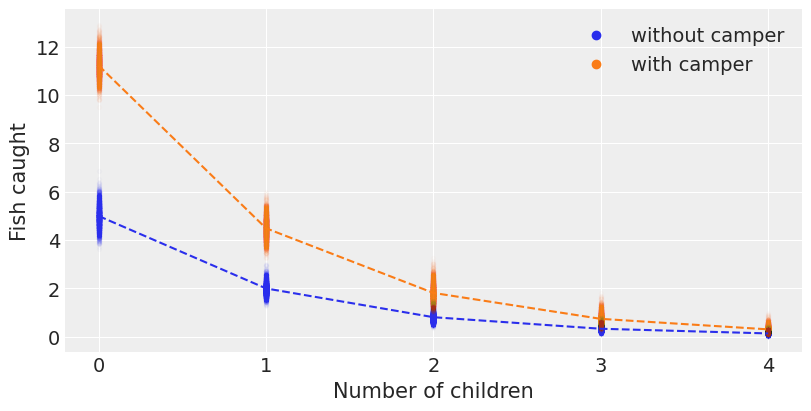

In [52]:
children = [0, 1, 2, 3, 4]

# Evaluate model.
posterior = az.extract(idata_ZIP_reg)
print(posterior)

without_camper = posterior['alpha'] + posterior['beta'][0] * xr.DataArray(children)
with_camper = without_camper + posterior['beta'][1]
fish_count_pred_0 = np.exp(without_camper)
fish_count_pred_1 = np.exp(with_camper)

# Plot.
_, ax = plt.subplots(figsize=(8, 4))
# - Plot data.
ax.plot(children, fish_count_pred_0.T, 'C0.', alpha=0.01)
ax.plot(children, fish_count_pred_1.T, 'C1.', alpha=0.01)
# - Plot model.
ax.plot(children, fish_count_pred_0.mean("sample"), 'C0', ls="--")
ax.plot(children, fish_count_pred_1.mean("sample"), 'C1', ls="--")
#
ax.set_xticks(children)
ax.set_xlabel('Number of children')
ax.set_ylabel('Fish caught')
ax.plot([], 'C0o', label='without camper')
ax.plot([], 'C1o', label='with camper')
plt.legend();

## Non-finite mixtures

In [16]:
def stick_breaking_truncated(alpha, h, K):
    """
    :param alpha: concentration param
    :param h: base distribution
    :param K: number of components

    :return locations and weights for the discrete distribution
    """
    # Generate K samples from a beta in [0, 1].
    betas = stats.beta.rvs(1, alpha, size=K)
    # print(betas)
    w = np.empty(K)
    # Multiple the 1 - betas to get a monotonic decreasing sequence.
    vals = np.cumprod(1 - betas[:-1])
    # print(vals)
    w = betas * np.concatenate(([1.0], vals))
    # print(w)
    # Build a K-vector rv from h.
    locs = h.rvs(size=K)
    # print(locs)
    return locs, w

In [17]:
# alphas = [1, 10, 100, 1000]
alpha = 1
h = stats.norm
K = 5

stick_breaking_truncated(alpha, h, K)

(array([-0.58770359,  0.67911391,  1.44545913,  1.34886868, -0.30937017]),
 array([0.41130585, 0.34774305, 0.01191545, 0.07217202, 0.13176426]))

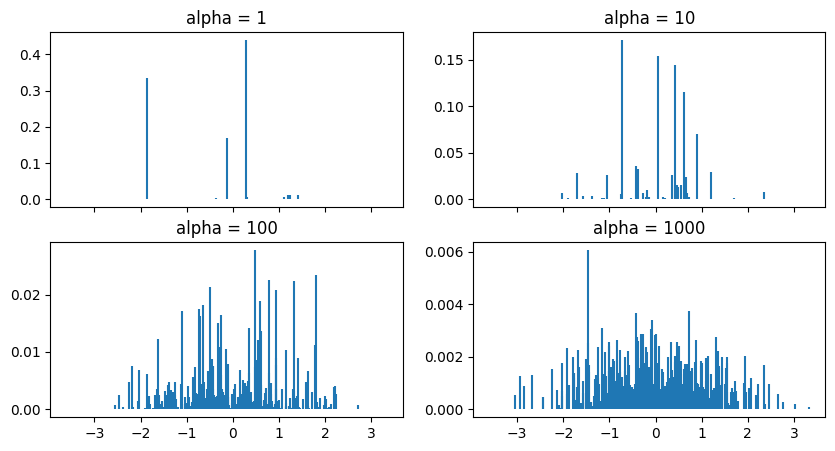

In [18]:
# Parameters DP
K = 500
H = stats.norm
alphas = [1, 10, 100, 1000]

_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
ax = np.ravel(ax)
for idx, alpha in enumerate(alphas):
    locs, w = stick_breaking_truncated(alpha, H, K)
    ax[idx].vlines(locs, 0, w, color="C0")
    ax[idx].set_title("alpha = {}".format(alpha))

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

# Parameters for the Beta distribution
alpha = 1
beta = 10

# Define the Beta distribution using PyMC
with pm.Model() as model:
    beta_dist = pm.Beta("beta_dist", alpha=alpha, beta=beta)

# Sample from the Beta distribution
samples = pm.sample_prior_predictive(samples=10, model=model)
# ['beta_dist']

# az.plot_
# samples["beta_dist"]

# # # Plot the distribution
# plt.hist(samples, bins=50, density=True)
# plt.title(f'Beta Distribution (alpha={alpha}, beta={beta})')
# plt.xlabel('Value')
# plt.ylabel('Density')
# plt.show()

Sampling: [beta_dist]


KeyError: 'beta_dist'

In [39]:
type(samples)

arviz.data.inference_data.InferenceData

In [45]:
type(samples["prior"])

xarray.core.dataset.Dataset

In [28]:
# More efficient formulation of the same problem.

K = 10


def stick_breaking(alpha, K):
    beta = pm.Beta("beta", 1.0, alpha, shape=K)
    w = beta * pt.concatenate([[1.0], pt.extra_ops.cumprod(1.0 - beta)[:-1]]) + 1e-6
    return w / w.sum()


with pm.Model() as model_DP:
    alpha = pm.Gamma("alpha", 2, 1)
    w = pm.Deterministic("w", stick_breaking(alpha, K))
    means = pm.Normal(
        "means",
        mu=np.linspace(cs_exp.min(), cs_exp.max(), K),
        sigma=5,
        shape=K,
        transform=pm.distributions.transforms.ordered,
    )
    sd = pm.HalfNormal("sd", sigma=10, shape=K)
    obs = pm.NormalMixture("obs", w, means, sigma=sd, observed=cs_exp.values)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, means, sd]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 217 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
